In [164]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from scipy.ndimage import gaussian_filter
from PIL import Image

%matplotlib inline

random = np.random.default_rng()
np.set_printoptions(precision=2)

import warnings
import torch
import torchvision
from torch import nn

import matplotlib as mpl
mpl.rc('image', cmap='gray')

from d2l import torch as d2l

In [165]:
class NumpyArrayDataset(Dataset):
    def __init__(self, path):
        self.npzfile = np.load(path)
        self.img_shape = self.npzfile[self.npzfile.files[0]][0].shape
    
    def __getitem__(self, idx):
        img = self.npzfile[self.npzfile.files[idx]].astype(np.single)
    
        entry = self.npzfile[self.npzfile.files[idx]]
    
        # For compatibility with the convolutional layers in the
        # network, we need to reshape the image to make it explicit 
        # that the image consists of one layer. 
        noisy_image = 100 * np.reshape(entry[0], (1, *self.img_shape))
        true_image  = 100 * np.reshape(entry[1], (1, *self.img_shape))
    
        # entry[0] is the noisy image, entry[1] is the true image. The
        # goal will be for the network to learn the mapping
        # noisy --> true.
        return (noisy_image.astype(np.single), true_image.astype(np.single))
    
    def __len__(self):
        return len(self.npzfile)

In [166]:
path = "shapes-dataset-new.npz"

# Load the shapes dataset as a PyTorch Dataset
shapes_dataset = NumpyArrayDataset(path)

transformer = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])

shapes_dataset.transform = transformer

# Construct the DataLoader
data_iter = DataLoader(shapes_dataset, batch_size=64, 
                       shuffle=False, num_workers=1)

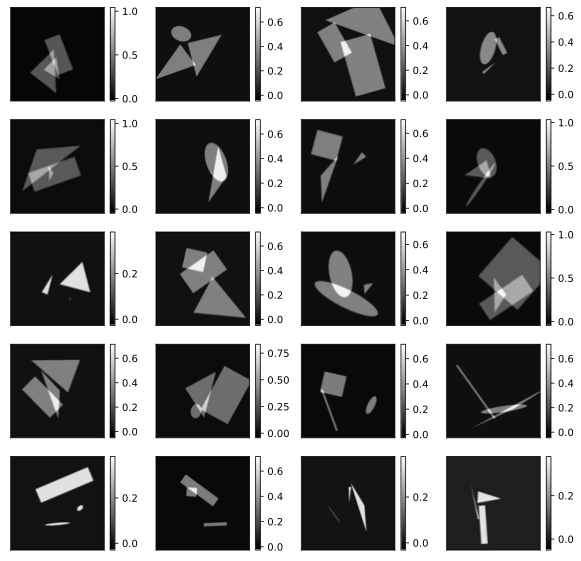

In [167]:
for X, y in data_iter:    
    fig, axs = plt.subplots(5, 4, figsize=(10, 10))
    for ax, img in zip(axs.flat, X):
        plot = ax.imshow(img[0])
        plt.colorbar(plot, ax=ax)
        ax.set_xticks([])
        ax.set_yticks([])
    break


In [168]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))


In [169]:
x = torch.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk(x).shape


torch.Size([2, 20, 32, 32])

In [170]:
x = torch.zeros((2, 3, 1, 1))
g_blk = G_block(20, strides=1, padding=0)
g_blk(x).shape


torch.Size([2, 20, 4, 4])

In [171]:
n_G = 32

net_G = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, stride=1),
    nn.Sigmoid()
)

for w in net_G.parameters():
    nn.init.normal_(w, 0, 0.2)

# net_G = nn.Sequential(
#     D_block(in_channels=1, out_channels=4),
#     G_block(in_channels=4, out_channels=1),
#     nn.Tanh())  # Output: (1, 128, 128)

In [172]:
# n_G = 32
# net_G = nn.Sequential(
#     G_block(in_channels=128**2, out_channels=n_G*16,
#             strides=1, padding=0),                   # Output: (32 * 16, 4, 4)
#     G_block(in_channels=n_G*16, out_channels=n_G*8), # Output: (32 * 8, 8, 8)
#     G_block(in_channels=n_G*8, out_channels=n_G*4),  # Output: (32 * 4, 16, 16)
#     G_block(in_channels=n_G*4, out_channels=n_G*2),  # Output: (32 * 2, 32, 32)
#     G_block(in_channels=n_G*2, out_channels=n_G),    # Output: (32 * 1, 64, 64)
#     nn.ConvTranspose2d(in_channels=n_G, out_channels=1,
#                        kernel_size=4, stride=2, padding=1, bias=False),
#     nn.Tanh())  # Output: (1, 128, 128)


In [173]:
x = torch.zeros((1, 1, 128, 128))
net_G(x).shape


torch.Size([1, 1, 128, 128])

In [174]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))
    

In [175]:
x = torch.zeros((2, 1, 16, 16))
d_blk = D_block(20, in_channels=1)
d_blk(x).shape


torch.Size([2, 20, 8, 8])

In [176]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D, in_channels=1),  # Output: (64, 64, 64)
    D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 32, 32)
    D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 16, 16)
    D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 8, 8)
    D_block(in_channels=n_D*8, out_channels=n_D*16), # Output: (64 * 16, 4, 4)
    nn.Conv2d(in_channels=n_D*16, out_channels=1,
              kernel_size=4, bias=False))  # Output: (1, 1, 1)

for w in net_D.parameters():
    nn.init.normal_(w, 0, 0.2)

In [177]:
x = torch.zeros((1, 1, 128, 128))
net_D(x).shape


torch.Size([1, 1, 1, 1])

In [178]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
              loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

In [179]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device='cpu'):
    flattener = nn.Flatten()
    
    loss = nn.BCEWithLogitsLoss(reduction='sum')

    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
#         metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        loss_D = 0
        loss_G = 0
        num_examples = 0
        for X, Z in data_iter:
            batch_size = X.shape[0]
#             Z = Z.view((batch_size, 1, 128, 128))
            Z = torch.normal(0, 1, size=Z.shape)
            X, Z = X.to(device), Z.to(device)
            
            loss_D += update_D(X, Z, net_D, net_G, loss, trainer_D)
            loss_G += update_G(Z, net_D, net_G, loss, trainer_G)
            num_examples += batch_size
            
        # Show generated examples
#         Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
#         fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
#         imgs = torch.cat(
#             [torch.cat([
#                 fake_x[i * 7 + j].cpu().detach() for j in range(7)], dim=1)
#              for i in range(len(fake_x)//7)], dim=0)
#         animator.axes[1].cla()
#         animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D = loss_D.item() / num_examples, 
        loss_G = loss_G.item() / num_examples
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')


TypeError: unsupported format string passed to tuple.__format__

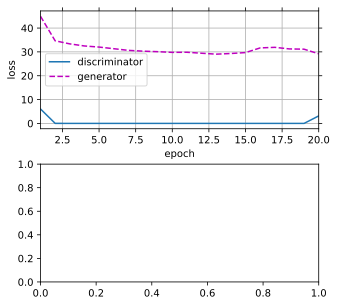

In [180]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net_G = net_G.to(device)
net_D = net_D.to(device)

latent_dim, lr, num_epochs = 128**2, 0.015, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim, device)


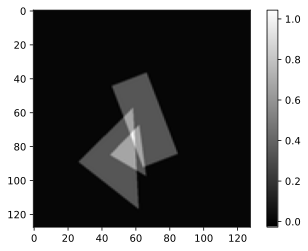

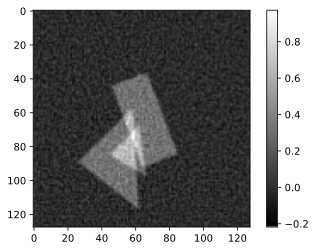

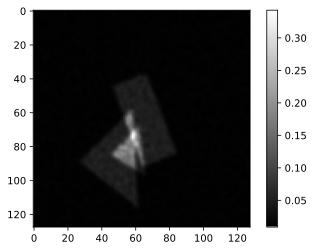

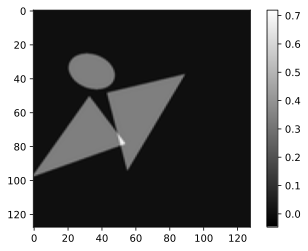

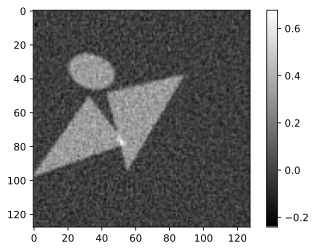

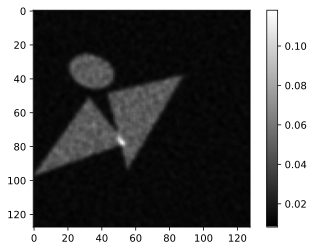

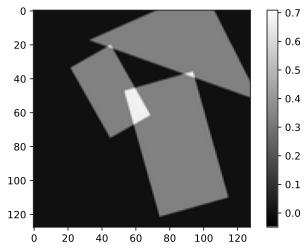

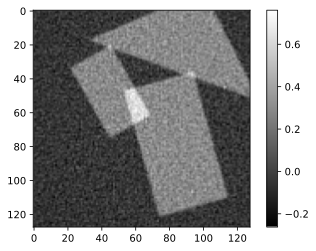

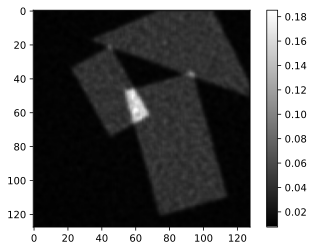

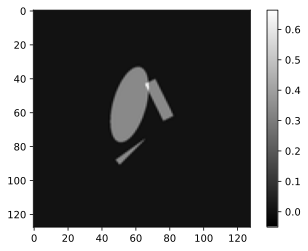

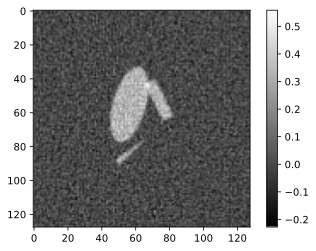

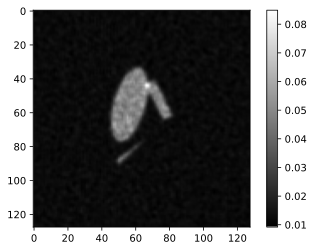

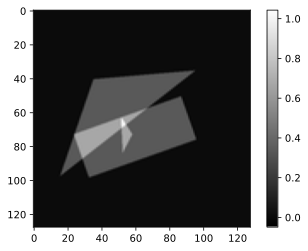

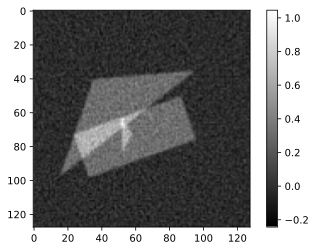

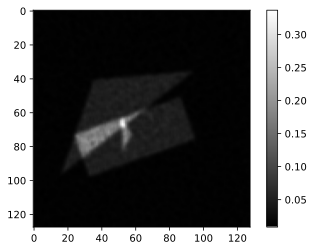

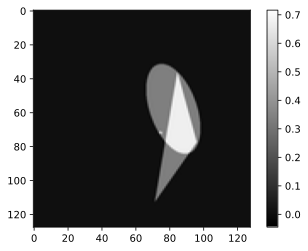

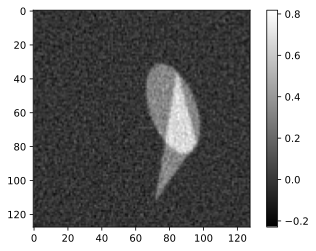

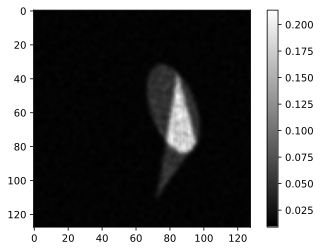

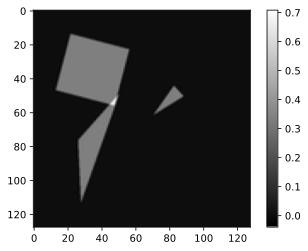

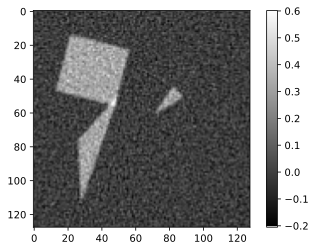

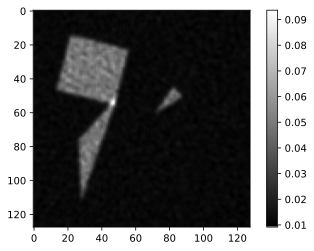

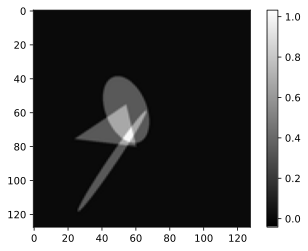

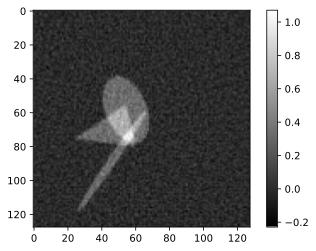

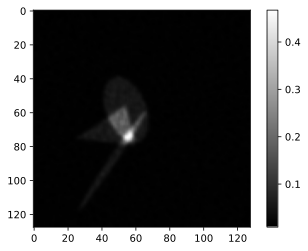

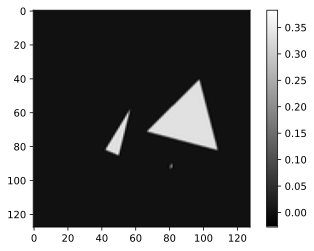

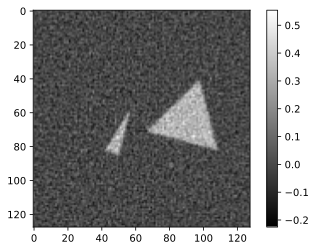

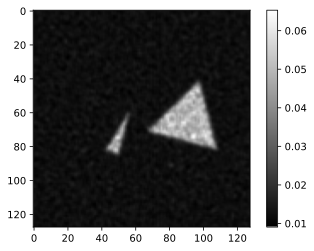

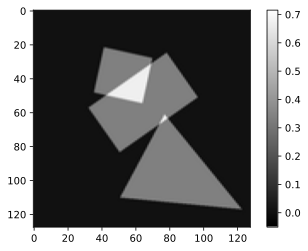

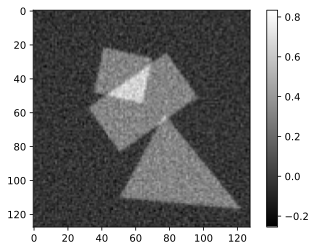

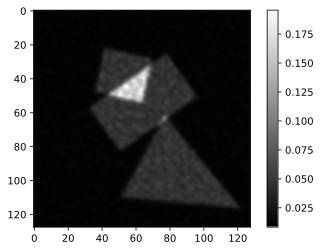

In [181]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net_G = net_G.to(device)
net_D = net_D.to(device)

for X, Z in data_iter:
    for orig_pic, noisy_pic, _ in zip(X, Z, range(10)):        
        pic = plt.imshow(orig_pic[0])
        plt.colorbar(pic)
#         print(net_D(orig_pic.view(1, 1, 128, 128).to('cuda')))
        plt.show()
        pic = plt.imshow(noisy_pic[0])
        plt.colorbar(pic)
        plt.show()
        fake_pic = net_G(noisy_pic.view(1, 1, 128, 128).to('cuda'))
#         print(net_D(fake_pic))
        pic = plt.imshow(fake_pic[0, 0].detach().cpu())
        plt.colorbar(pic)
        plt.show()
    
    break